# Multi-Class Classification

This Colab explores multi-class classification problems through the classic MNIST dataset.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=multiclass_tf2-colab&hl=en#scrollTo=wYG5qXpP5a9n

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Understand the classic MNIST problem.
  * Create a deep neural network that performs multi-class classification.
  * Tune the deep neural network.

This exercise introduces image classification with machine learning.

## The Dataset
  
This MNIST dataset contains a lot of examples:

* The MNIST training set contains 60,000 examples.
* The MNIST test set contains 10,000 examples.

Each example contains a pixel map showing how a person wrote a digit. For example, the following images shows how a person wrote the digit `1` and how that digit might be represented in a 14x14 pixel map (after the input data is normalized). 

![Two images. The first image shows a somewhat fuzzy digit one. The second image shows a 14x14 floating-point array in which most of the cells contain 0 but a few cells contain values between 0.0 and 1.0. The pattern of nonzero values corresponds to the image of the fuzzy digit in the first image.](https://www.tensorflow.org/images/MNIST-Matrix.png)

Each example in the MNIST dataset consists of:

* A label specified by a [rater](https://developers.google.com/machine-learning/glossary/#rater).  Each label must be an integer from 0 to 9.  For example, in the preceding image, the rater would almost certainly assign the label `1` to the example.
* A 28x28 pixel map, where each pixel is an integer between 0 and 255. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent various shades of gray.  

This is a multi-class classification problem with 10 output classes, one for each digit.

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

## Load the dataset

`tf.keras` provides a set of convenience functions for loading well-known datasets. Each of these convenience functions does the following:

* Loads both the training set and the test set.
* Separates each set into features and labels.

The relevant convenience function for MNIST is called `mnist.load_data()`:

In [2]:
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(), 
    #把灰階從0~255壓縮到0~1
    download=False
    # DOWNLOAD_MNIST = False    #第一次用要先下載data,所以是True
)

In [3]:
test_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False
    # DOWNLOAD_MNIST = False    #第一次用要先下載data,所以是True
    )

In [4]:
print(train_data.train_data.shape)
print(train_data.train_labels.shape)
print(test_data.train_data.shape)
print(test_data.train_labels.shape)

(x_train, y_train),(x_test, y_test) = (train_data.train_data, train_data.train_labels), \
(test_data.train_data, test_data.train_labels)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Notice that `mnist.load_data()` returned four separate values:

* `x_train` contains the training set's features.
* `y_train` contains the training set's labels.
* `x_test` contains the test set's features.
* `y_test` contains the test set's labels.

**Note:** The MNIST .csv training set is already shuffled.

## View the dataset

The .csv file for the California Housing Dataset contains column names (for example, `latitude`, `longitude`, `population`). By contrast, the .csv file for MNIST does not contain column names. Instead of column names, you use ordinal numbers to access different subsets of the MNIST dataset. In fact, it is probably best to think of `x_train` and `x_test` as three-dimensional NumPy arrays:  



In [5]:
# Output example #2917 of the training set.
x_train[2917]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Alternatively, you can call `matplotlib.pyplot.imshow` to interpret the preceding numeric array as an image. 

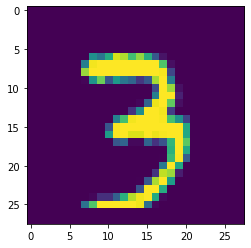

In [6]:
# Use false colors to visualize the array.
plt.imshow(x_train[2917])

In [7]:
# Output row #10 of example #2917.
x_train[2917][10]

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  58, 254, 216,  11,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=torch.uint8)

In [8]:
# Output pixel #16 of row #10 of example #2900.
x_train[2900][10][16]

tensor(0, dtype=torch.uint8)

## Task 1: Normalize feature values

Complete the following code cell to map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0. Store the floating-point values in `x_train_normalized` and `x_test_normalized`.

In [9]:
#@title Double-click to see a solution to Task 1. 

x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][10]) # Output a normalized row

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5529, 1.0000,
        0.6667, 0.1137, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.003
n_epochs = 50
batch_size = 4000
validation_split = 0.2

In [11]:
import torch.utils.data as data

class MyDataset(Dataset):
 
    def __init__(self, x, y):      

        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int64)    
           

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    
train_set = MyDataset(x_train_normalized, y_train)
test_ds = MyDataset(x_test_normalized, y_test)   

# Random split
train_set_size = int(len(train_set) * (1-validation_split))
valid_set_size = len(train_set) - train_set_size
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size])


train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


## Create a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.
* Any [regularization](https://developers.google.com/machine-learning/glossary/#regularization) layers.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.  The activation function of the output layer is [softmax](https://developers.google.com/machine-learning/glossary/#softmax), which will yield 10 different outputs for each example. Each of the 10 outputs provides the probability that the input example is a certain digit.

**Note:** Unlike several of the recent Colabs, this exercise does not define feature columns or a feature layer.  Instead, the model will train on the NumPy array.

In [12]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(28*28, 32),   
                    nn.Dropout(0.2),
                    nn.Linear(32, 10),
                    nn.Softmax(dim=1)
                )
        
    def forward(self, x):        
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [13]:
from torch.autograd import Variable

model = Sequential()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

loss_func = nn.CrossEntropyLoss() 
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_train_acc = []

epoch_valid_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch 
        X = Variable(X)
        y = Variable(y)
        
        y_hat = model(X)       
        
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

        pred = torch.max(y_hat, 1, keepdim=False)[1]
        acc = (pred == y).sum() / len(y)        
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch           
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = torch.max(y_hat, 1, keepdim=False)[1]
        acc = (pred == y).sum() / len(y)  
        
        valid_accs.append(acc)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accs = sum(valid_accs) / len(valid_accs)
    epoch_valid_loss.append(valid_loss)
    epoch_valid_acc.append(valid_accs)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/050 ]           train_loss = 2.16099 accuracy = 0.46606  |           valid_loss = 1.96427 val_accuracy = 0.66533



[ Epoch | 002/050 ]           train_loss = 1.86125 accuracy = 0.71525  |           valid_loss = 1.75679 val_accuracy = 0.76942



[ Epoch | 003/050 ]           train_loss = 1.71606 accuracy = 0.80617  |           valid_loss = 1.66090 val_accuracy = 0.85192



[ Epoch | 004/050 ]           train_loss = 1.64977 accuracy = 0.85292  |           valid_loss = 1.62146 val_accuracy = 0.87200



[ Epoch | 005/050 ]           train_loss = 1.61862 accuracy = 0.87319  |           valid_loss = 1.60230 val_accuracy = 0.88217



[ Epoch | 006/050 ]           train_loss = 1.60184 accuracy = 0.88254  |           valid_loss = 1.59033 val_accuracy = 0.88917



[ Epoch | 007/050 ]           train_loss = 1.59150 accuracy = 0.89050  |           valid_loss = 1.58286 val_accuracy = 0.89450



[ Epoch | 008/050 ]           train_loss = 1.58464 accuracy = 0.89517  |           valid_loss = 1.57694 val_accuracy = 0.89858



[ Epoch | 009/050 ]           train_loss = 1.57920 accuracy = 0.89810  |           valid_loss = 1.57297 val_accuracy = 0.90092



[ Epoch | 010/050 ]           train_loss = 1.57391 accuracy = 0.90217  |           valid_loss = 1.56921 val_accuracy = 0.90275



[ Epoch | 011/050 ]           train_loss = 1.57054 accuracy = 0.90417  |           valid_loss = 1.56649 val_accuracy = 0.90575



[ Epoch | 012/050 ]           train_loss = 1.56763 accuracy = 0.90629  |           valid_loss = 1.56400 val_accuracy = 0.90733



[ Epoch | 013/050 ]           train_loss = 1.56488 accuracy = 0.90756  |           valid_loss = 1.56196 val_accuracy = 0.90817



[ Epoch | 014/050 ]           train_loss = 1.56198 accuracy = 0.91075  |           valid_loss = 1.56049 val_accuracy = 0.90892



[ Epoch | 015/050 ]           train_loss = 1.56061 accuracy = 0.91154  |           valid_loss = 1.55885 val_accuracy = 0.90875



[ Epoch | 016/050 ]           train_loss = 1.55892 accuracy = 0.91200  |           valid_loss = 1.55773 val_accuracy = 0.91092



[ Epoch | 017/050 ]           train_loss = 1.55763 accuracy = 0.91371  |           valid_loss = 1.55650 val_accuracy = 0.91125



[ Epoch | 018/050 ]           train_loss = 1.55624 accuracy = 0.91421  |           valid_loss = 1.55561 val_accuracy = 0.91258



[ Epoch | 019/050 ]           train_loss = 1.55466 accuracy = 0.91510  |           valid_loss = 1.55510 val_accuracy = 0.91142



[ Epoch | 020/050 ]           train_loss = 1.55400 accuracy = 0.91485  |           valid_loss = 1.55385 val_accuracy = 0.91242



[ Epoch | 021/050 ]           train_loss = 1.55175 accuracy = 0.91696  |           valid_loss = 1.55319 val_accuracy = 0.91308



[ Epoch | 022/050 ]           train_loss = 1.55121 accuracy = 0.91792  |           valid_loss = 1.55211 val_accuracy = 0.91500



[ Epoch | 023/050 ]           train_loss = 1.55026 accuracy = 0.91871  |           valid_loss = 1.55153 val_accuracy = 0.91442



[ Epoch | 024/050 ]           train_loss = 1.55008 accuracy = 0.91773  |           valid_loss = 1.55121 val_accuracy = 0.91483



[ Epoch | 025/050 ]           train_loss = 1.54931 accuracy = 0.91925  |           valid_loss = 1.55014 val_accuracy = 0.91533



[ Epoch | 026/050 ]           train_loss = 1.54742 accuracy = 0.92042  |           valid_loss = 1.55011 val_accuracy = 0.91575



[ Epoch | 027/050 ]           train_loss = 1.54716 accuracy = 0.92067  |           valid_loss = 1.54941 val_accuracy = 0.91600



[ Epoch | 028/050 ]           train_loss = 1.54549 accuracy = 0.92210  |           valid_loss = 1.54915 val_accuracy = 0.91725



[ Epoch | 029/050 ]           train_loss = 1.54542 accuracy = 0.92215  |           valid_loss = 1.54848 val_accuracy = 0.91583



[ Epoch | 030/050 ]           train_loss = 1.54523 accuracy = 0.92256  |           valid_loss = 1.54818 val_accuracy = 0.91683



[ Epoch | 031/050 ]           train_loss = 1.54393 accuracy = 0.92323  |           valid_loss = 1.54760 val_accuracy = 0.91758



[ Epoch | 032/050 ]           train_loss = 1.54340 accuracy = 0.92367  |           valid_loss = 1.54740 val_accuracy = 0.91850



[ Epoch | 033/050 ]           train_loss = 1.54251 accuracy = 0.92471  |           valid_loss = 1.54690 val_accuracy = 0.91892



[ Epoch | 034/050 ]           train_loss = 1.54372 accuracy = 0.92327  |           valid_loss = 1.54662 val_accuracy = 0.91883



[ Epoch | 035/050 ]           train_loss = 1.54211 accuracy = 0.92398  |           valid_loss = 1.54625 val_accuracy = 0.91842



[ Epoch | 036/050 ]           train_loss = 1.54191 accuracy = 0.92460  |           valid_loss = 1.54601 val_accuracy = 0.91933



[ Epoch | 037/050 ]           train_loss = 1.54024 accuracy = 0.92617  |           valid_loss = 1.54587 val_accuracy = 0.91975



[ Epoch | 038/050 ]           train_loss = 1.54114 accuracy = 0.92510  |           valid_loss = 1.54573 val_accuracy = 0.91867



[ Epoch | 039/050 ]           train_loss = 1.53956 accuracy = 0.92633  |           valid_loss = 1.54525 val_accuracy = 0.92050



[ Epoch | 040/050 ]           train_loss = 1.53931 accuracy = 0.92706  |           valid_loss = 1.54474 val_accuracy = 0.92008



[ Epoch | 041/050 ]           train_loss = 1.53977 accuracy = 0.92598  |           valid_loss = 1.54520 val_accuracy = 0.91992



[ Epoch | 042/050 ]           train_loss = 1.54009 accuracy = 0.92590  |           valid_loss = 1.54487 val_accuracy = 0.91900



[ Epoch | 043/050 ]           train_loss = 1.53937 accuracy = 0.92594  |           valid_loss = 1.54420 val_accuracy = 0.92083



[ Epoch | 044/050 ]           train_loss = 1.53813 accuracy = 0.92748  |           valid_loss = 1.54408 val_accuracy = 0.91950



[ Epoch | 045/050 ]           train_loss = 1.53782 accuracy = 0.92767  |           valid_loss = 1.54377 val_accuracy = 0.92058



[ Epoch | 046/050 ]           train_loss = 1.53850 accuracy = 0.92727  |           valid_loss = 1.54364 val_accuracy = 0.92183



[ Epoch | 047/050 ]           train_loss = 1.53713 accuracy = 0.92881  |           valid_loss = 1.54378 val_accuracy = 0.92042



[ Epoch | 048/050 ]           train_loss = 1.53638 accuracy = 0.92912  |           valid_loss = 1.54419 val_accuracy = 0.91967



[ Epoch | 049/050 ]           train_loss = 1.53719 accuracy = 0.92813  |           valid_loss = 1.54470 val_accuracy = 0.91917



[ Epoch | 050/050 ]           train_loss = 1.53655 accuracy = 0.92848  |           valid_loss = 1.54367 val_accuracy = 0.92083
Defined the build_model and train_model functions.


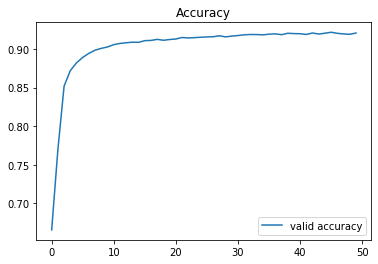

In [14]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_valid_acc)
plt.title('Accuracy')
plt.legend(['valid accuracy'])
plt.savefig('acc.png')
plt.show()

In [19]:
model.eval()

# These are used to record information in validation.
test_loss = []
test_accs = []

# Iterate the validation set by batches.
for batch in tqdm(test_loader):
    X, y = batch   
   
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse

    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    pred = torch.max(y_hat, 1, keepdim=False)[1]
    acc = (pred == y).sum() / len(y)  
    test_accs.append(acc)

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

# Print the information.
print(f"loss = {test_loss:.5f} accuracy = {test_acc:.5f}")


loss = 1.53121 accuracy = 0.93117


## Task 2: Optimize the model

Experiment with the following:

* number of hidden layers 
* number of nodes in each layer
* dropout regularization rate

What trends did you discover?  Can you reach at least 98% accuracy against the test set? 


